In [12]:
# Step 1: Import libraries
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

# Step 2: Define MySQL connection credentials
user = "root"               # your MySQL username
password = "Tricia1!"       # your MySQL password
host = "localhost"
database = "ecommerce_db"

# Step 3: Create SQLAlchemy engine
engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}/{database}")

# Step 4: Load cust_churn table into pandas
df = pd.read_sql("SELECT * FROM cust_churn;", engine)

# Step 5: Quick peek and summary
print(df.head())
print(df.info())


    Age  Gender Country        City  Membership_Years  Login_Frequency  \
0  43.0    Male  France   Marseille               2.9             14.0   
1  36.0    Male      UK  Manchester               1.6             15.0   
2  45.0  Female  Canada   Vancouver               2.9             10.0   
3  56.0  Female     USA    New York               2.6             10.0   
4  35.0    Male   India       Delhi               3.1             29.0   

   Session_Duration_Avg  Pages_Per_Session  Cart_Abandonment_Rate  \
0                  27.4                6.0                   50.6   
1                  42.7               10.3                   37.7   
2                  24.8                1.6                   70.9   
3                  38.4               14.8                   41.7   
4                  51.4                NaN                   19.1   

   Wishlist_Items  ...  Email_Open_Rate  Customer_Service_Calls  \
0             3.0  ...             17.9                     9.0   
1     

In [13]:
print(df.describe())

                Age  Membership_Years  Login_Frequency  Session_Duration_Avg  \
count  22936.000000      22936.000000     22936.000000          22936.000000   
mean      37.824948          2.992217        12.402511             28.179194   
std       11.887699          2.069219         7.847783             10.889729   
min        5.000000          0.100000         0.000000              1.000000   
25%       29.000000          1.400000         6.000000             20.200000   
50%       38.000000          2.500000        12.000000             27.400000   
75%       46.000000          4.100000        18.000000             35.300000   
max      200.000000         10.000000        44.000000             75.600000   

       Pages_Per_Session  Cart_Abandonment_Rate  Wishlist_Items  \
count       21553.000000           22936.000000    22936.000000   
mean            9.082490              55.360377        4.525375   
std             3.799094              16.166117        3.219688   
min        

In [16]:
# Step 6: Define behavioral metrics to analyze
behavior_cols = [
    'Login_Frequency',
    'Total_Purchases',
    'Cart_Abandonment_Rate',
    'Pages_Per_Session',
    'Session_Duration_Avg'
]

# Step 6b: Convert Columns to Numeric (so we can aggregate data)
for col in behavior_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # convert to numeric, set invalid parsing as NaN

# Step 7: Calculate average of each metric for churned vs active customers
behavior_summary = df.groupby('Churned')[behavior_cols].mean()
print("\nAverage behavioral metrics by churn status:\n", behavior_summary)


Average behavioral metrics by churn status:
          Login_Frequency  Total_Purchases  Cart_Abandonment_Rate  \
Churned                                                            
0              13.250570        14.212378              52.870918   
1              10.152278        12.121759              61.965888   

         Pages_Per_Session  Session_Duration_Avg  
Churned                                           
0                 9.552557             29.592538  
1                 7.831878             24.429038  


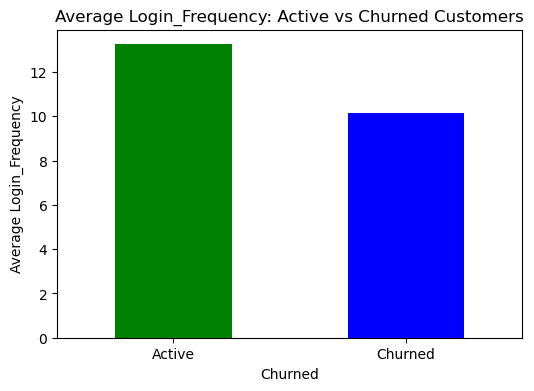

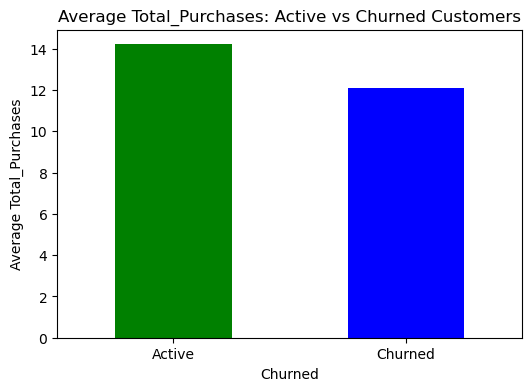

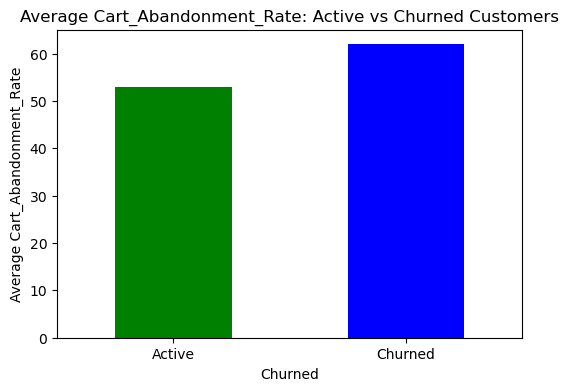

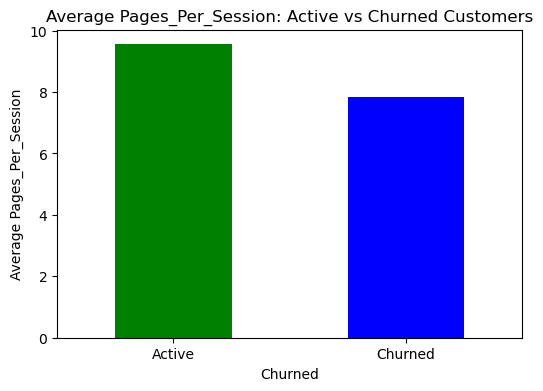

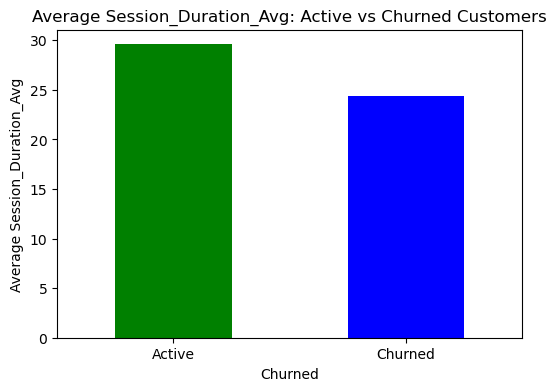

In [17]:
# Step 8: Visualization - compare churned vs active for each metric
for col in behavior_cols:
    plt.figure(figsize=(6,4))
    behavior_summary[col].plot(kind='bar', color=['green','blue'])
    plt.xticks([0,1], ['Active','Churned'], rotation=0)
    plt.ylabel(f'Average {col}')
    plt.title(f'Average {col}: Active vs Churned Customers')
    plt.show()


=== Mean & Median LTV Summary ===
   Churned     Mean_LTV  Median_LTV
0        0  1446.805875     1266.79
1        1  1425.423236     1132.73

=== Quartile Breakdown ===
   Churned LTV_Quartile  count         mean
0        0            1   8888   615.680638
1        0            2   8887  1059.653952
2        0            3   8887  1503.412075
3        0            4   8888  2608.439643
4        1            1   3613   383.558254
5        1            2   3613   837.976573
6        1            3   3611  1645.131498
7        1            4   3613  2835.148240


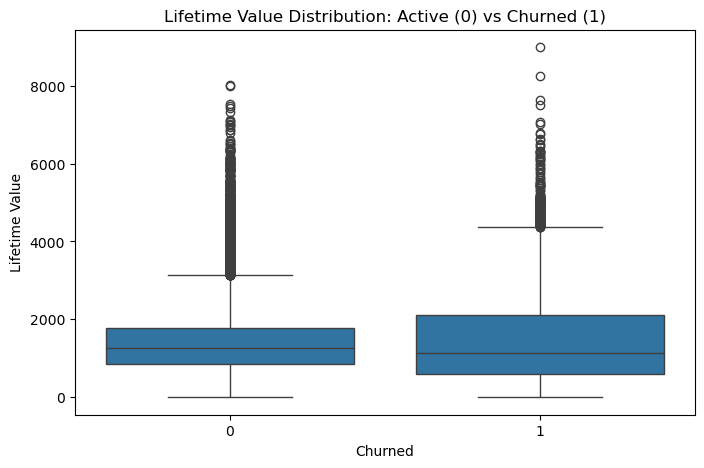

In [23]:
# ------------------------------
# Query #4: Lifetime Value Analysis
# ------------------------------

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Load dataset
df = pd.read_csv("ecommerce_customer_churn_dataset.csv")

# 2️⃣ Separate active vs churned
active = df[df['Churned'] == 0].copy()
churned = df[df['Churned'] == 1].copy()

# 3️⃣ Compute mean and median LTV
mean_median_summary = pd.DataFrame({
    'Churned': [0, 1],
    'Mean_LTV': [active['Lifetime_Value'].mean(), churned['Lifetime_Value'].mean()],
    'Median_LTV': [active['Lifetime_Value'].median(), churned['Lifetime_Value'].median()]
})

print("=== Mean & Median LTV Summary ===")
print(mean_median_summary)

# 4️⃣ Create LTV quartiles (1 = lowest, 4 = highest)
active['LTV_Quartile'] = pd.qcut(active['Lifetime_Value'], 4, labels=[1,2,3,4])
churned['LTV_Quartile'] = pd.qcut(churned['Lifetime_Value'], 4, labels=[1,2,3,4])

# 5️⃣ Aggregate quartiles: count and mean LTV
active_quartiles = active.groupby('LTV_Quartile', observed=True)['Lifetime_Value'].agg(['count','mean']).reset_index()
active_quartiles['Churned'] = 0

churned_quartiles = churned.groupby('LTV_Quartile', observed=True)['Lifetime_Value'].agg(['count','mean']).reset_index()
churned_quartiles['Churned'] = 1

quartiles_combined = pd.concat([active_quartiles, churned_quartiles], ignore_index=True)
quartiles_combined = quartiles_combined[['Churned', 'LTV_Quartile', 'count', 'mean']]

print("\n=== Quartile Breakdown ===")
print(quartiles_combined)

# 6️⃣ Optional: Quick visualization
plt.figure(figsize=(8,5))
sns.boxplot(x='Churned', y='Lifetime_Value', data=df)
plt.title("Lifetime Value Distribution: Active (0) vs Churned (1)")
plt.xlabel("Churned")
plt.ylabel("Lifetime Value")
plt.show()
